# 读取数据

In [1]:
import pickle
road_zip={}
orthogonal_list={}
pointers={}
node_dict={}
node_dict_amap={}
way_list=[]
with open('road_zip.pkl','rb') as f:
    road_zip=pickle.load(f)
with open('map_nodes.pkl','rb') as f:
    node_dict=pickle.load(f)
with open('map_nodes_amap.pkl','rb') as f:
    node_dict_amap=pickle.load(f)
with open('graph.pkl','rb') as f:
    orthogonal_list=pickle.load(f)
with open('graph_pointers.pkl','rb') as f:
    pointers=pickle.load(f)
with open('map_ways.pkl','rb') as f:
    way_list=pickle.load(f)

# 将高德路段与拓扑图对应

In [2]:
#从道路方向信息中解析出道路的起讫点
def decodeDirection(direction):
    begin,end='',''
    if direction[0]=='从':
        strlist=direction.split('到')
        begin=strlist[0][1:]
        end=strlist[1]
    elif direction[-2:]=='附近':
        begin=direction[:-2]
        end=direction[:-2]
    return begin,end
def findRelatedEdges(name,s,d):
    sv_list,dv_list=[],[]
    for vertex in way_vertex_dict[name]:
        in_list=[edge[0] for edge in orthogonal_list[vertex][0]]
        out_list=[edge[0] for edge in orthogonal_list[vertex][1]]
        if s in in_list or s in out_list:
            sv_list.append(vertex)
        if d in in_list or d in out_list:
            dv_list.append(vertex)

    related_edges=[]
    #能找到起讫点
    if len(sv_list)>0 and len(dv_list)>0:
        route=[]
        for s in sv_list:
            history_v=[s]
            answer_v=[]
            next_seq=[[s]]
            while len(next_seq)>0:
                seq=next_seq.pop()
                v=seq[-1]
                edge=orthogonal_list[v][0]+orthogonal_list[v][1]
                for e in edge:
                    if e[0]==name and e[1] not in history_v:
                        history_v.append(e[1])
                        if e[1] in dv_list:
                            answer_v.append(seq+[e[1]])
                        else:
                            next_seq.append(seq+[e[1]])
            route.extend(answer_v)
        for rt in route:
            for i in range(1,len(rt)):
                a,b=rt[i-1],rt[i]
                is_find=False
                v,no='',0
                for i,e in enumerate(orthogonal_list[a][1]):
                    if e[0]==name and e[1]==b:
                        is_find=True
                        v=a
                        no=i
                        break
                if not is_find:
                    for i,e in enumerate(orthogonal_list[b][1]):
                        if e[0]==name and e[1]==a:
                            is_find=True
                            v=b
                            no=i
                            break
                if not is_find:
                    print('err')
                elif (v,no) not in related_edges:
                    related_edges.append((v,no))
    #找不到起讫点，则将所有路段纳入相关边
    else:
#         for p in pointers[name]:
#             if p[0]==begin or p[0]==end or p[1]==begin or p[1]==end:
#                 related_edges.append((p[2],p[3]))
        for v in way_vertex_dict[name]:
            for no,e in enumerate(orthogonal_list[v][1]):
                if e[0]==name:
                    related_edges.append((v,no))
    return related_edges

In [3]:
from copy import deepcopy
way_vertex_list=[]
for way in way_list:
    vertex_list=[]
    for node in way[1]:
        if node in orthogonal_list:
            vertex_list.append(node)
    if len(vertex_list)>0:
        way_vertex_list.append((way[0],vertex_list))
way_vertex_dict={}
for way in way_vertex_list:
    if way[0] not in way_vertex_dict:
        way_vertex_dict[way[0]]=way[1]
    else:
        way_vertex_dict[way[0]].extend(way[1])
for way in way_vertex_dict:
    way_vertex_dict[way]=list(set(way_vertex_dict[way]))

keys=list(road_zip.keys())
road_edges={}
for road in keys:
    if road[0] in way_vertex_dict:
        begin,end=decodeDirection(road[1])
        related_edges=findRelatedEdges(road[0],begin,end)
        road_edges[road]=related_edges

spatial_maps=deepcopy(orthogonal_list)
for road,edges in road_edges.items():
    for edge in edges:
        v,oute=edge[0],edge[1]
        rname=spatial_maps[v][1][oute][0]
        dv=spatial_maps[v][1][oute][1]
        spatial_maps[v][1][oute].append(road)
        for i in range(len(spatial_maps[dv][0])):
            if spatial_maps[dv][0][i][0]==rname:
                spatial_maps[dv][0][i].append(road)

In [4]:
import numpy as np
node_id2no={Id:No for No,Id in enumerate(orthogonal_list)}
matrix=[[0 for _ in range(len(orthogonal_list))] for _ in range(len(orthogonal_list))]
for v,e in orthogonal_list.items():
    for eout in e[1]:
        matrix[node_id2no[v]][node_id2no[eout[1]]]=1
        matrix[node_id2no[eout[1]]][node_id2no[v]]=1
        
import cv2 as cv
sample=np.array(matrix)
image=255*sample
cv.imwrite("graph_martix.png", image)

True

绘制匹配路段图

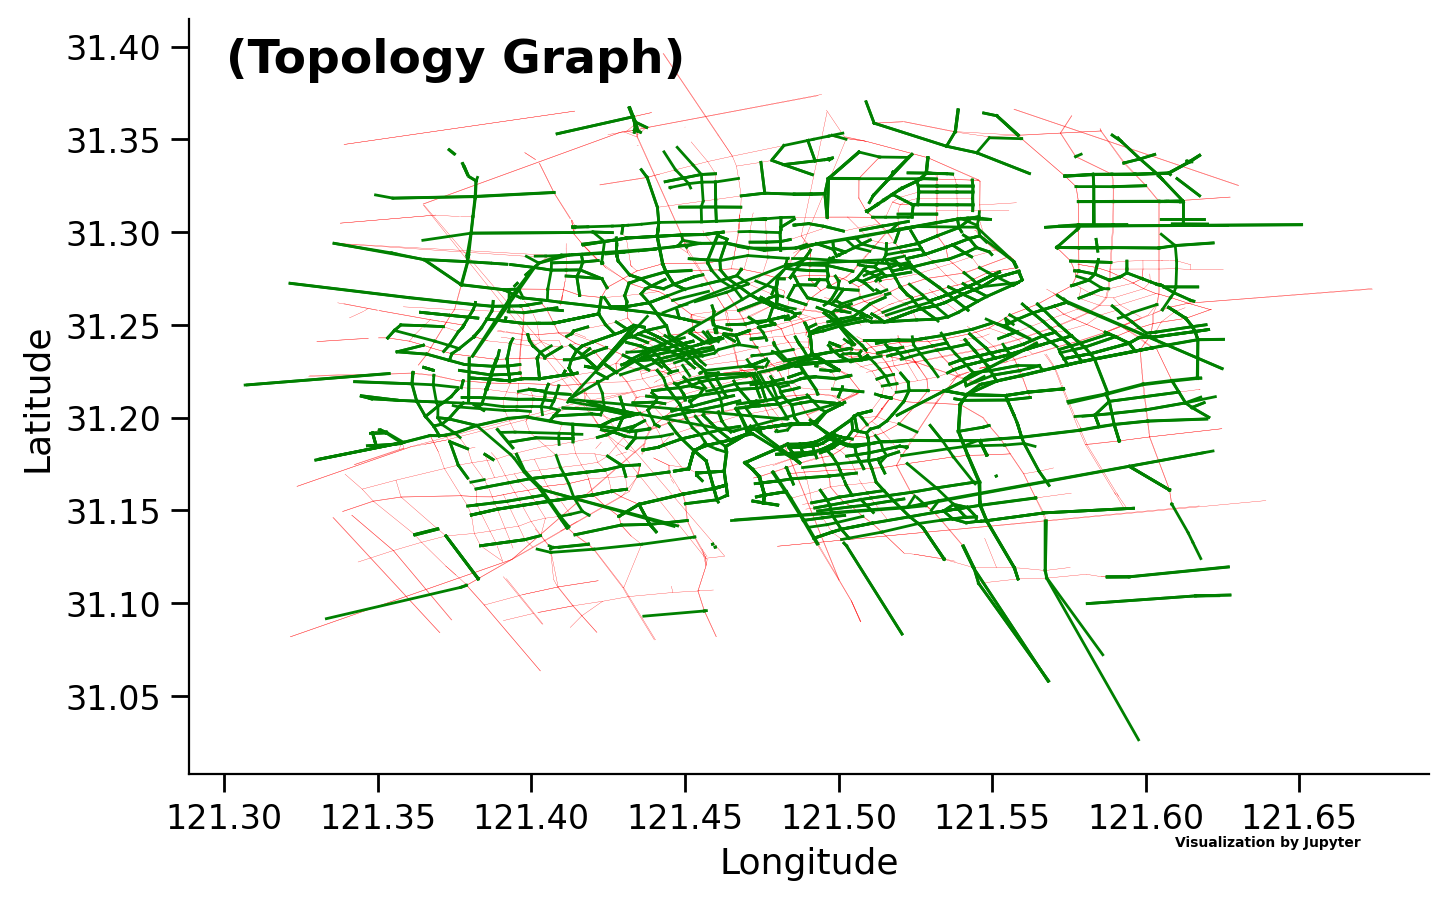

In [5]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(8,5),dpi=200)
ref=node_dict_amap
for key,value in orthogonal_list.items():
    for e in value[1]:
        ax.plot([float(ref[key][0]),float(ref[e[1]][0])],[float(ref[key][1]),float(ref[e[1]][1])],color='r',linewidth=.1)
for road,edges in road_edges.items():
    for edge in edges:
        a=edge[0]
        b=orthogonal_list[a][1][edge[1]][1]
        ax.plot([float(ref[a][0]),float(ref[b][0])],[float(ref[a][1]),float(ref[b][1])],color='g',linewidth=1)

ax.tick_params(direction='out',labelsize=12,length=6.5,width=1,top=False,right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Latitude',fontsize=13)
ax.set_xlabel('Longitude',fontsize=13)
text_font = {'size':'17','weight':'bold','color':'black'}
ax.text(.03,.93,'(Topology Graph)',transform = ax.transAxes,fontdict=text_font,zorder=4)
ax.text(.87,-.08,'\nVisualization by Jupyter',transform = ax.transAxes, ha='center', va='center',fontsize = 5,color='black',fontweight='bold')
fig.show()

# 模式挖掘

In [4]:
import numpy as np
data=np.array(list(road_zip.values()))[:,:,:,1]#road,date,time,regular_speed
data=data.swapaxes(0,1)#date,road,time,regular_speed
data=np.concatenate(data,axis=1)#road,datetime,regular_speed
data=data.T#datetime,road,regular_speed
adj_matrix=[[0 for j in range(len(road_zip))] for i in range(len(road_zip))]
k=5    #k代表检查当前时间点之前kT范围内所有产生拥堵的路段
g=3    #g代表将当前道路的g阶邻居纳入检查范围
old_cjst_group=[[] for _ in range(k)]    #前kT时间段内曾经发生拥堵的道路集合，每个T各成一个列表
new_cjst=[]    #记录当前时间内发生拥堵的路段
#按照时间遍历
for Tdata in data:
    new_cjst=[]    #清空新拥堵道路集合
    old_cjst=[]    #构建历史拥堵道路集合
    for cjst in old_cjst_group:
        old_cjst.extend(cjst)
    #按照道路遍历
    for i,Rdata in enumerate(Tdata):
        #如果道路发生了拥堵
        if Rdata<=0.5 and Rdata!=0.0:
            road=list(road_zip.keys())[i]
            #将道路的对应矩阵的值增加
            adj_matrix[i][i]+=1
            #如果道路拥堵是新发生的
            if road not in old_cjst:
                #通过广度优先遍历当前道路的g阶邻居道路并筛选出曾经拥堵的g阶邻居
                roads_stack=[road]
                adj_roads=[]
                for _ in range(g):
                    new_roads_stack=[]
                    while len(roads_stack)>0:
                        current=roads_stack.pop()
                        if current not in road_edges:
                            continue
                        for edge in road_edges[current]:
                            s=edge[0]
                            d=spatial_maps[s][1][edge[1]][1]
                            for e in spatial_maps[s][0]:
                                if len(e)>2 and e[2]!=current and e[2] not in adj_roads and e[2] in old_cjst:
                                    adj_roads.append(e[2])
                                    new_roads_stack.append(e[2])
                            for e in spatial_maps[s][1]:
                                if len(e)>2 and e[2]!=current and e[2] not in adj_roads and e[2] in old_cjst:
                                    adj_roads.append(e[2])
                                    new_roads_stack.append(e[2])
                            for e in spatial_maps[d][0]:
                                if len(e)>2 and e[2]!=current and e[2] not in adj_roads and e[2] in old_cjst:
                                    adj_roads.append(e[2])
                                    new_roads_stack.append(e[2])
                            for e in spatial_maps[d][1]:
                                if len(e)>2 and e[2]!=current and e[2] not in adj_roads and e[2] in old_cjst:
                                    adj_roads.append(e[2])
                                    new_roads_stack.append(e[2])
                    roads_stack=new_roads_stack
                #每一个曾经拥堵的祖先道路都对当前道路施加影响，将对应的矩阵的边的值增加
                for adj in adj_roads:
                    adj_matrix[list(road_zip.keys()).index(adj)][i]+=1
            new_cjst.append(road)
    #更新历史拥堵道路
    for i in range(1,k):
        old_cjst_group[i-1]=old_cjst_group[i]
    old_cjst_group[k-1]=new_cjst
#绘制矩阵
import cv2 as cv
sample=np.array(adj_matrix)
sample=np.int64(sample>0)
sample=255.0*sample
cv.imwrite("adj_matrix.png", sample)

True

48


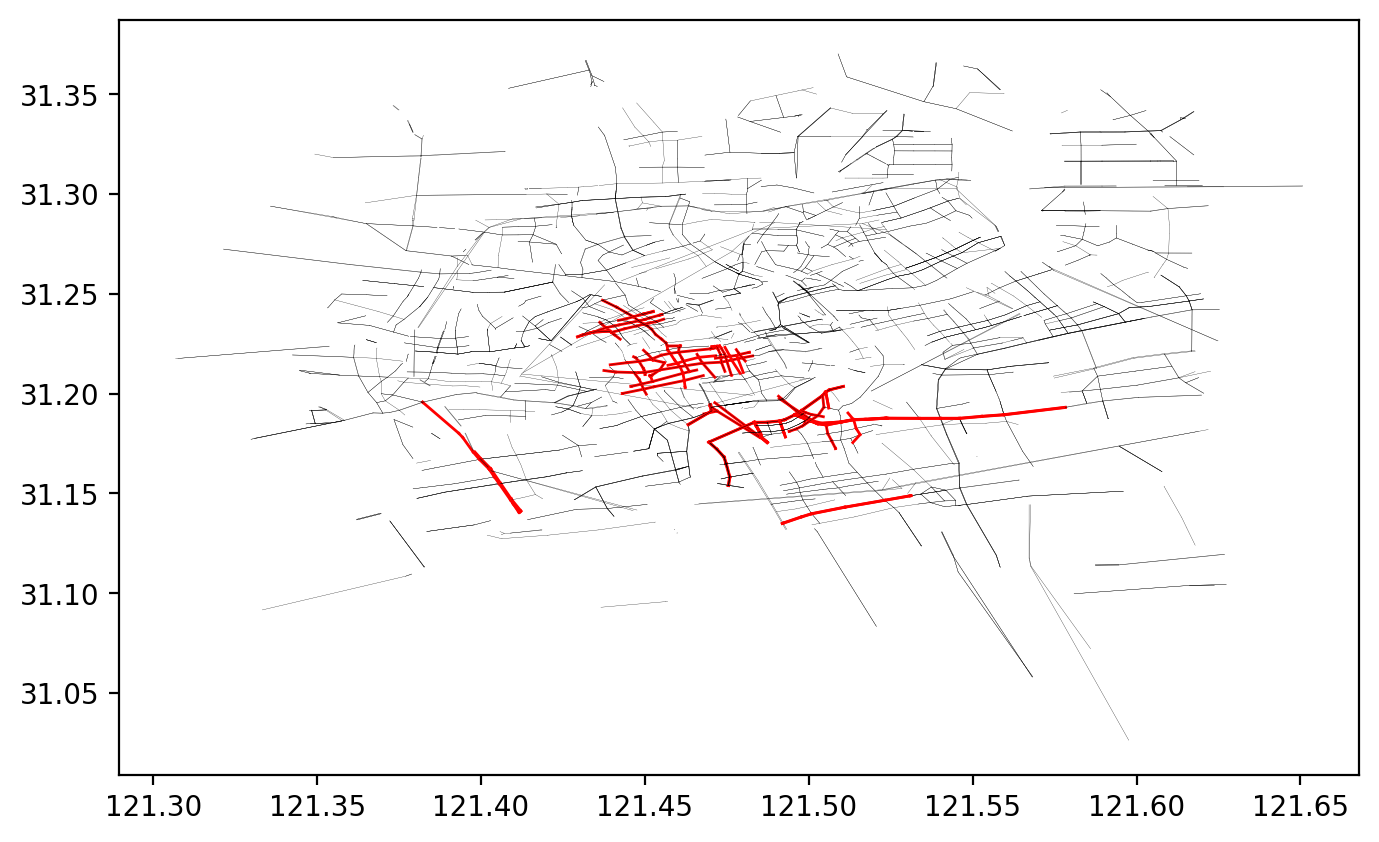

In [20]:
import matplotlib.pyplot as plt
critical_road=[]
for i in range(len(adj_matrix)):
    if np.sum(adj_matrix[i])-adj_matrix[i][i]>2500:
        critical_road.append(list(road_zip.keys())[i])
print(len(critical_road))
ref=node_dict_amap
fig,ax = plt.subplots(figsize=(8,5),dpi=200)
for road in road_zip.keys():
    if road not in road_edges:
        continue
    for edge in road_edges[road]:
        a=edge[0]
        b=orthogonal_list[a][1][edge[1]][1]
        if road in critical_road:
            ax.plot([float(ref[a][0]),float(ref[b][0])],[float(ref[a][1]),float(ref[b][1])],color='red',linewidth=1)
        else:
            ax.plot([float(ref[a][0]),float(ref[b][0])],[float(ref[a][1]),float(ref[b][1])],color='black',linewidth=.1)
fig.show()

# 道路演化分析

In [5]:
import matplotlib.pyplot as plt
from progressbar import ProgressBar,Percentage,Bar,Timer,ETA,FileTransferSpeed
widgets = [
    'Progress: ',
    Percentage(), ' ',
    Bar('#'), ' ',
    Timer(), ' ',
    ETA(), ' ',
    FileTransferSpeed()
]

data=np.array(list(road_zip.values()))[:,:,:,0]
data=data.swapaxes(0,1)
data=np.concatenate(data,axis=1)
data=data.T
ref=node_dict_amap
status2color=['black','green','orange','red']

bar = ProgressBar(widgets=widgets, maxval=len(data)).start()
for t,tdata in enumerate(data):
    if t<6080:
        bar.update(t+1)
        continue
    fig,ax = plt.subplots(figsize=(8,5),dpi=200)
    for i,road in enumerate(keys):
        if road in road_edges:
            for edge in road_edges[road]:
                a=edge[0]
                b=orthogonal_list[a][1][edge[1]][1]
                ax.plot([float(ref[a][0]),float(ref[b][0])],[float(ref[a][1]),float(ref[b][1])],color=status2color[int(tdata[i])],linewidth=1)
    fig.savefig(f'images/img{t:0>7d}.png')
    plt.close(fig)
    bar.update(t+1)
bar.finish()

Progress: 100% |##############| Elapsed Time: 0:01:02 Time: 0:01:02  97.54  B/s


合成视频

In [6]:
import cv2
import os
file_list=sorted(os.listdir('images'))
file_list.pop(0)

fourcc=cv2.VideoWriter_fourcc(*'XVID')
videowrite=cv2.VideoWriter('evolution.mp4',fourcc,20,(1600,1000))#20是帧数，size是图片尺寸
print(videowrite.isOpened())
img_array=[]
for filename in file_list:
    img = cv2.imread('images/'+filename)
    if img is None:
        print(f'{filename} do not exist!')
        continue
    img_array.append(img)
for img in img_array:
    videowrite.write(img)
videowrite.release()
print('true')

True
true
